# LLM における System メッセージの役割 🤖

LLM の `system` メッセージは、モデルの振る舞いを決める重要な要素です。
例えば、同じ `user` メッセージを入力しても、`system` メッセージを変えるだけで AI の出力が大きく変わります。
今回は、これを `Gradio` で試しながら理解していきます！🚀

## 1. 実装：System メッセージの影響を試してみる 🔍
`system` メッセージを変えることで、AI の応答がどのように変化するのかを `Gradio` で実験してみましょう！


In [ ]:
from openai import OpenAI
import gradio as gr
import os
from dotenv import load_dotenv

load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
client = OpenAI()

def chat_with_system(system_prompt, user_input):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_input}
    ]
    print(messages)
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages
    )
    return response.choices[0].message.content

gr.Interface(
    fn=chat_with_system,
    inputs=["text", "text"],
    outputs="text",
    title="System メッセージの影響をテスト"
).launch(debug=True)

## 2. 発展：LLM同士をバトルさせてみる🔥💥  

ここまでで会話履歴と system メッセージの仕組みを学んできましたが、  
これをちょっと応用して、**2つの LLM に違うキャラ設定を与えて会話させてみる** ってのも面白いんです！  

例えば、AとBの2つのBOTを用意して、それぞれに違う性格の system メッセージを設定すると…  
あとは会話履歴を繋ぐだけで、LLM同士が勝手にバトル開始！🔥  

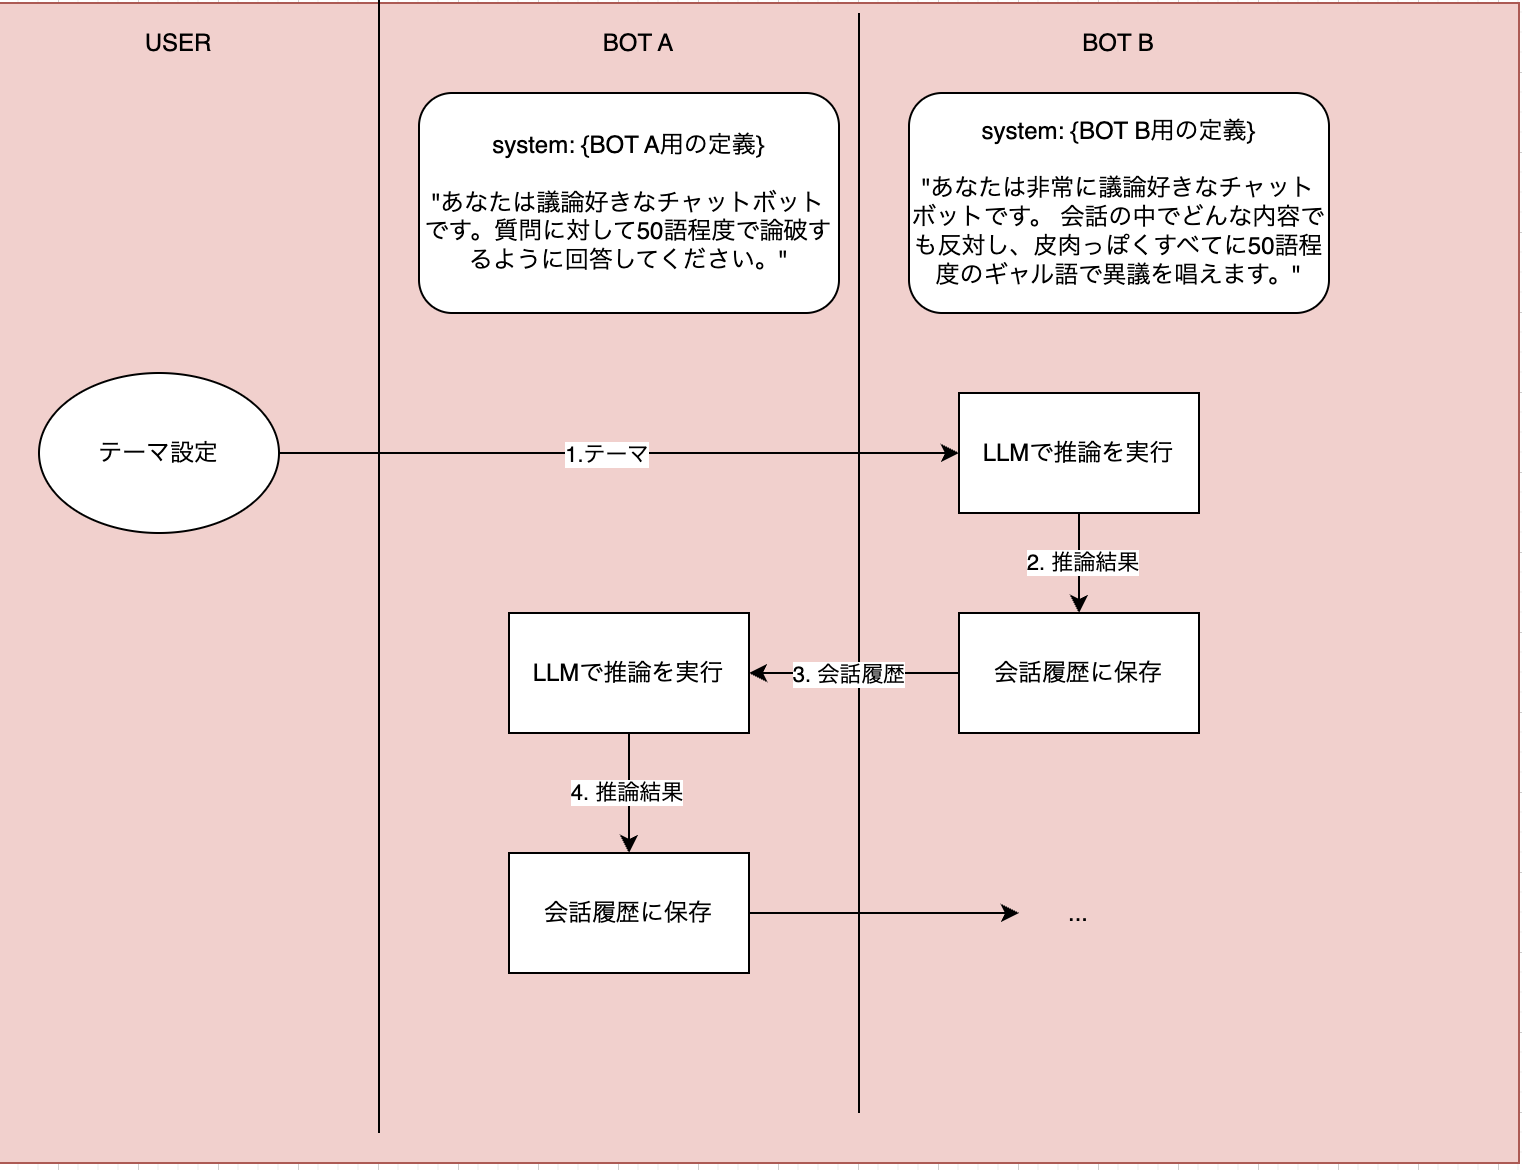

In [ ]:
import gradio as gr
import time
from openai import OpenAI
import os
from dotenv import load_dotenv
import copy

# 環境変数の読み込み
load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
client = OpenAI()

# システムプロンプト
system_prompt_bot = "あなたは非常に議論好きなチャットボットです。 \
会話の中でどんな内容でも反対し、皮肉っぽくすべてに50語程度のギャル語で異議を唱えます。"

system_prompt_user = "あなたは議論好きなチャットボットです。質問に対して50語程度で論破するように回答してください。"

# 役割のスワップ
def swap_roles(messages):
    messages_copy = copy.deepcopy(messages)  # 元のリストをコピー
    for msg in messages_copy:
        if msg["role"] == "user":
            msg["role"] = "assistant"
        elif msg["role"] == "assistant":
            msg["role"] = "user"
    return messages_copy

# メッセージを追加
def add_message(history, message):
    for x in message["files"]:
        history.append({"role": "user", "content": {"path": x}})
    if message["text"] is not None:
        history.append({"role": "user", "content": message["text"]})
    return history, gr.MultimodalTextbox(value=None, interactive=False)

# 自動メッセージの追加
def add_auto_message(history):
    messages = [
        {"role": "system", "content": system_prompt_user},
    ] + history
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=swap_roles(messages)
    )
    # **OpenAIのTTS APIで音声ファイルを作成**
    audio_response = client.audio.speech.create(
        model="tts-1",
        voice="echo",  # 利用可能なボイス: alloy, echo, fable, onyx, nova, shimmer
        input=response.choices[0].message.content
    )

    audio_path = "response_bot.mp3"
    with open(audio_path, "wb") as f:
        f.write(audio_response.content)
    
    history.append({"role": "user", "content": response.choices[0].message.content})
    return history, gr.MultimodalTextbox(value=None, interactive=False), audio_path

# **ボットの応答を生成し、音声ファイルを作成**
def bot(history: list):
    messages = [
        {"role": "system", "content": system_prompt_bot},
    ] + history
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages
    )

    bot_response = response.choices[0].message.content
    history.append({"role": "assistant", "content": bot_response})

    # **OpenAIのTTS APIで音声ファイルを作成**
    audio_response = client.audio.speech.create(
        model="tts-1",
        voice="sage",  # 利用可能なボイス: alloy, echo, fable, onyx, nova, shimmer
        input=bot_response
    )

    audio_path = "response_bot.mp3"
    with open(audio_path, "wb") as f:
        f.write(audio_response.content)
    return history, audio_path  # **音声ファイルを返す**

def wait_time():
    time.sleep(15)  # 音声再生が終了するまでの想定待機時間

# **GradioのUI**
with gr.Blocks() as demo:
    chatbot = gr.Chatbot(elem_id="chatbot", bubble_full_width=False, type="messages")
    audio_output = gr.Audio(label="読み上げ音声", autoplay=True)

    chat_input = gr.MultimodalTextbox(
        interactive=True,
        file_count="multiple",
        placeholder="Enter message or upload file...",
        show_label=False,
        sources=["microphone", "upload"],
    )

    # **メッセージを送信**
    chat_msg = chat_input.submit(
        add_message, [chatbot, chat_input], [chatbot, chat_input]
    )

    # **ボットの応答 + 音声を生成**
    bot_msg = chat_msg
    for _ in range(2):  # 2回のラリー
        bot_msg = bot_msg.then(bot, chatbot, [chatbot, audio_output], api_name="bot_response")\
                         .then(wait_time, None, None)\
                         .then(add_auto_message, chatbot, [chatbot, chat_input,audio_output])\
                         .then(wait_time, None, None)\

    bot_msg.then(lambda: gr.MultimodalTextbox(interactive=True), None, [chat_input])

demo.launch()
